# Join plots for models

Join in one graph the plots for all p

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{1}{T} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right) $$ 
con
$$ series(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 

In [3]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res

def model_function(x: float,p,coefs):
    a1,a2 = coefs
    return a1*(1/serie_divergente(x,p,z=1,a=a2))

## Get data

In [4]:
data_path = Path("../../../data/").resolve()
file_all_tc = 'all_inv_Tc.csv'
df_inv_all_tc = pd.read_csv(os.path.join(data_path,file_all_tc))
file_params = "inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_2_parms_params_curves.csv"
df_params = pd.read_csv(os.path.join(data_path,"Extrapolation",file_params),index_col=0)
file_extrapol_val = "inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_2_parms_extrapol_values.csv"
df_extrapol_val = pd.read_csv(os.path.join(data_path,"Extrapolation",file_extrapol_val),index_col=0)

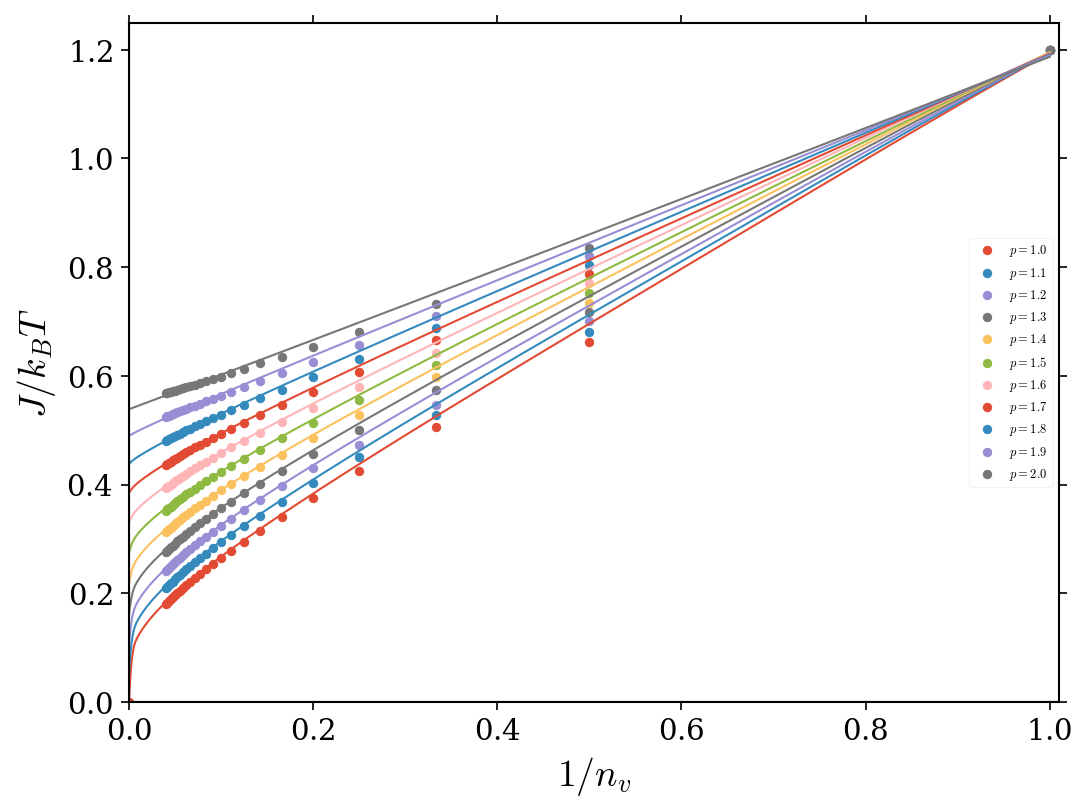

In [8]:
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
epsilon = 0.001
# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(8, 6), dpi=150)
grid_spec = GridSpec(1, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])


for index,column in enumerate(COLUMNS):
    # Get exponent
    p = float(column.replace("P",""))

    # Get inv_tc per col
    y_data_all = df_inv_all_tc.loc[:, column]

    x_data = np.array(df_inv_all_tc.loc[y_data_all.notnull(), "1/nv"])
    y_data = np.array(y_data_all.loc[y_data_all.notnull()])
    
    # add value at nv=1
    x_data = np.concatenate([x_data,[1]])
    y_data = np.concatenate([y_data,[1.19968]])
    
    # add value at nv=infty
    if column == 'P1.0':
        x_data = np.insert(x_data,0,0)
        y_data = np.insert(y_data,0,0)
    
    # get coefs adjusted
    coefs = df_params[column].values

    # get regular function
    x_extrapol = np.arange(1, 101, 1)
    y_extrapol = []
    for x_point in x_extrapol:
        y_extrapol.insert(0,model_function(x_point,p,coefs))
    x_extrapol = 1/x_extrapol
    x_extrapol = x_extrapol[::-1]
    y_extrapol = np.array(y_extrapol)
    # add the 1/nv = 0 value
    x_extrapol = np.insert(x_extrapol,0,0)
    y_extrapol = np.insert(y_extrapol,0,df_extrapol_val.loc['infty'][column])
    # interpolate the points for regulirize the curve
    extrapol_funct = interp.UnivariateSpline(x_extrapol,
                            y_extrapol,
                            s=0, k=4)
    x_data_fine = np.linspace(0, 1, num=1024)
    y_data_fine = extrapol_funct(x_data_fine)
    ax.plot(x_data_fine, y_data_fine, lw=1, color='C'+str(index))
    
    if index == 10:
        ax.scatter(x_data, y_data, marker="o", color='C'+str(index),label = '$p=2.0$')
    else:
        ax.scatter(x_data, y_data, marker="o", color='C'+str(index),label = '$p=1.{}$'.format(index))

ax.set_xlabel(r"$1 / n_v$")
ax.set_ylabel(r"$J / k_B T$")

ax.set_ylim(0, 1.25)
ax.set_xlim(0, 1.01)

# ax.set_ylim(0, 0.5)
# ax.set_xlim(0, 0.2)

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.legend(
    #('$p=1.0$','$p=1.1$','$p=1.2$','$p=1.3$','$p=1.4$','$p=1.5$','$p=1.6$','$p=1.7$','$p=1.8$','$p=1.9$','$p=2.0$'),
          loc ="center right")
# ax.set_xscale("log")
# ax.set_yscale("log")

pyplot.draw()
pyplot.show()